In [11]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")

df = pd.read_csv(os.path.join(path, os.listdir(path)[0]), header=0, parse_dates=True)
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [12]:
df = df.rename(columns={"Month": "ds", "#Passengers": "y"})
df.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [13]:
df_train = df.iloc[:-24]
df_test = df.iloc[-24:]


In [14]:
df_train

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
115,1958-08,505
116,1958-09,404
117,1958-10,359
118,1958-11,310


In [15]:
model = Prophet()
model.fit(df_train)


17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=24, freq='M')
future.tail()

,ds
139,1960-07-31
140,1960-08-31
141,1960-09-30
142,1960-10-31
143,1960-11-30


In [18]:
forecast = model.predict(future)


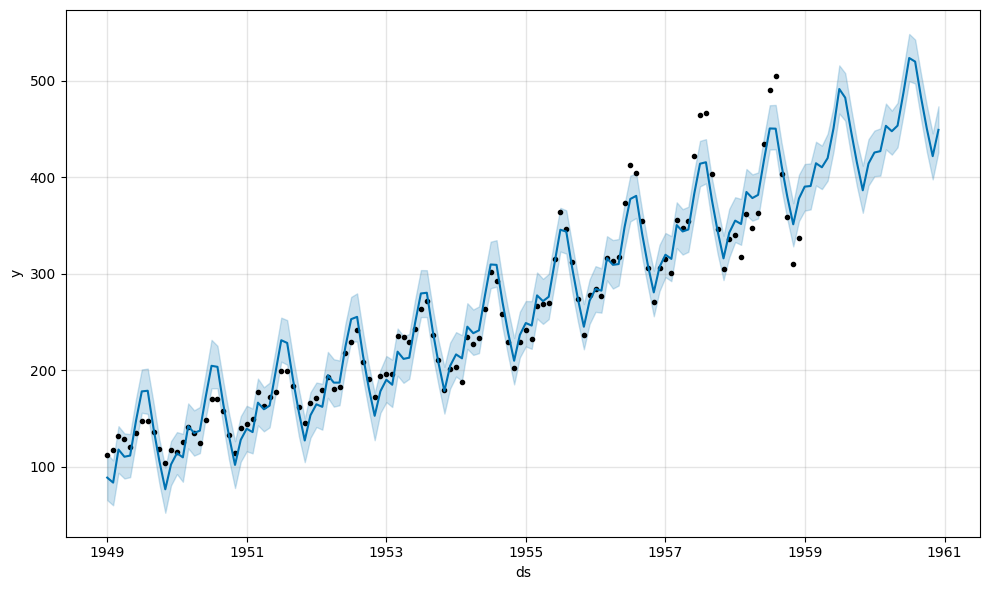

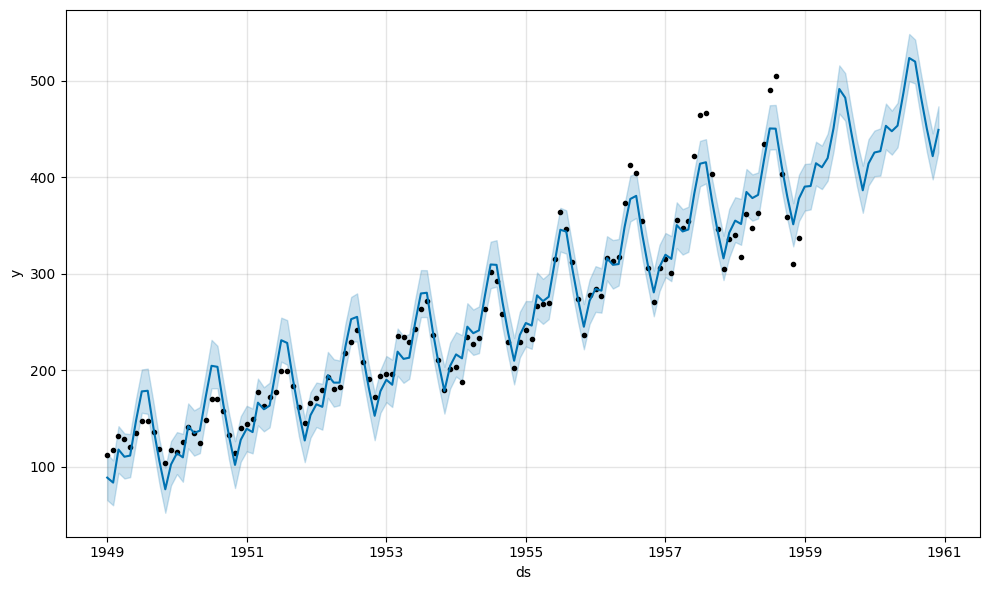

In [20]:
model.plot(forecast)


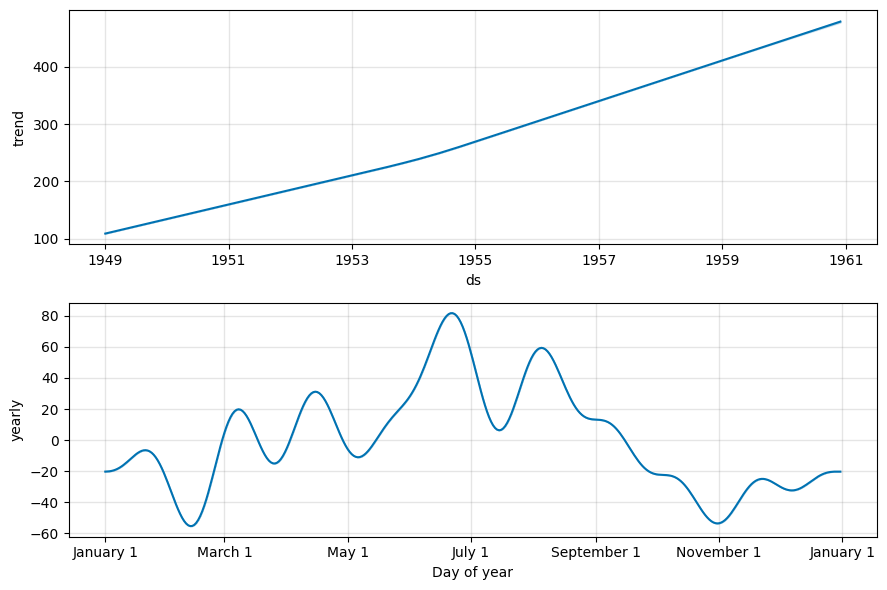

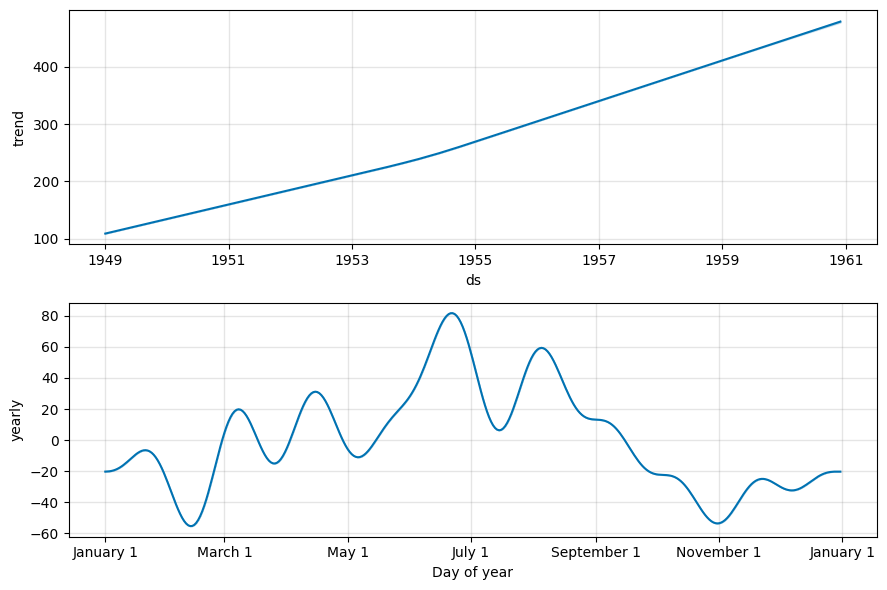

In [21]:
model.plot_components(forecast)

In [22]:
rmse = mean_squared_error(df_test['y'], forecast['yhat'].tail(24))
print(f'Root mean square error (RMSE): {rmse}')

Root mean square error (RMSE): 1602.417751515827


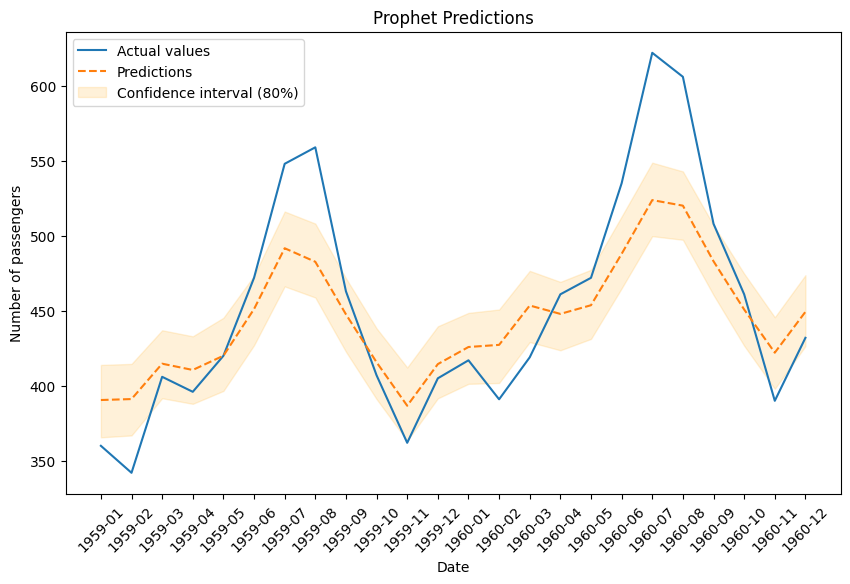

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], df['y'].tail(24), label='Actual values')
plt.plot(df_test['ds'], forecast['yhat'].tail(24), label='Predictions', linestyle='--')
plt.fill_between(df_test['ds'], forecast['yhat_lower'].tail(24), forecast['yhat_upper'].tail(24), 
                 color='orange', alpha=0.15, label='Confidence interval (80%)')
plt.title('Prophet Predictions')
plt.xlabel('Date')
plt.xticks(df_test['ds'], rotation=45)
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

In [24]:
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [25]:
param_fixed = {  
    'seasonality_mode': 'multiplicative',
    'daily_seasonality': False,
    'weekly_seasonality': False,
    'yearly_seasonality': True
}

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1, 10, 15],
    'changepoint_range': [0.5, 0.75, 0.95]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model_cv = Prophet(**param_fixed, **params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(model_cv, initial='2920 days', period='365 days', horizon = '365 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1]

In [26]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
display(tuning_results)


best_params = all_params[np.argmin(rmses)]
best_score = tuning_results['rmse'].min()
print(best_params)
print(best_score)


model_tuned = Prophet(**best_params, **param_fixed)
model_tuned.fit(df_train)
predictions_tuned = model_tuned.predict(future)

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,rmse
0,0.01,0.1,0.50,18.627784
1,0.01,0.1,0.75,29.315111
2,0.01,0.1,0.95,30.599061
3,0.01,1.0,0.50,18.478237
4,0.01,1.0,0.75,30.062924
5,0.01,1.0,0.95,27.848956
6,0.01,10.0,0.50,18.255299
7,0.01,10.0,0.75,29.843121
8,0.01,10.0,0.95,28.996522
9,0.01,15.0,0.50,18.403416


18:01:16 - cmdstanpy - INFO - Chain [1] start processing
18:01:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'changepoint_range': 0.5}
18.255298692431243


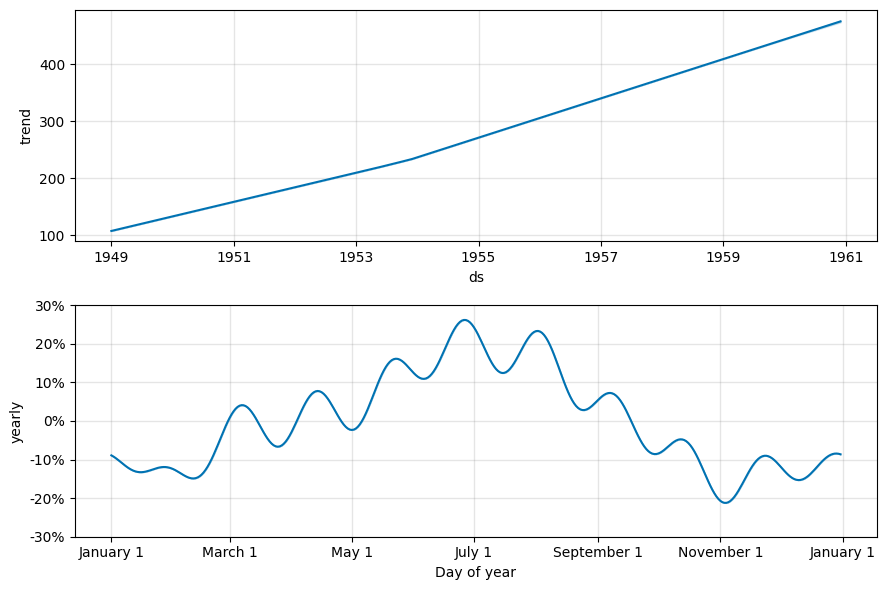

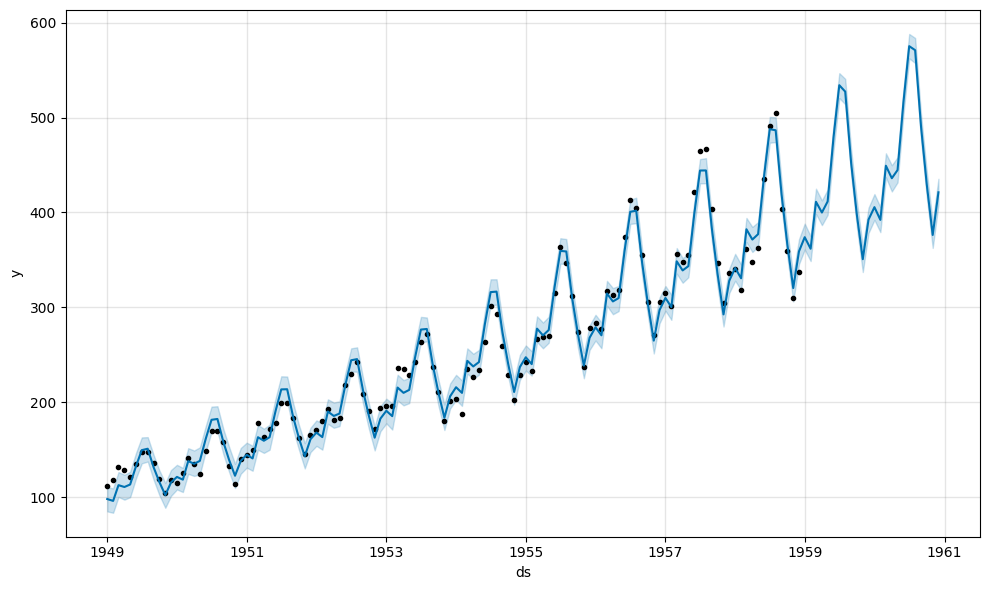

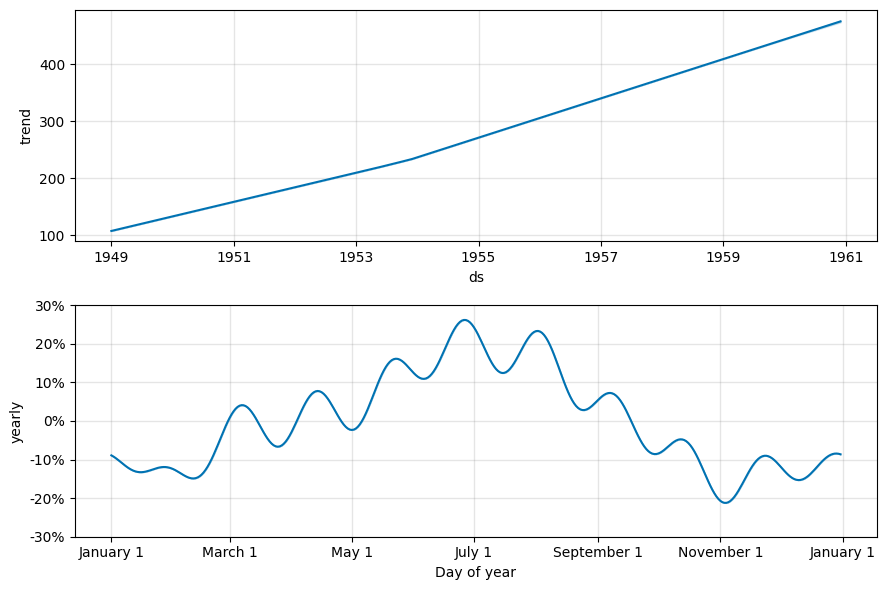

In [27]:
model_tuned.plot(predictions_tuned)
model_tuned.plot_components(predictions_tuned)


In [28]:
rmse = mean_squared_error(df_test['y'], predictions_tuned['yhat'].tail(24))
print(f'Root Mean Square Error (RMSE): {rmse}')

Root Mean Square Error (RMSE): 426.3146597224884


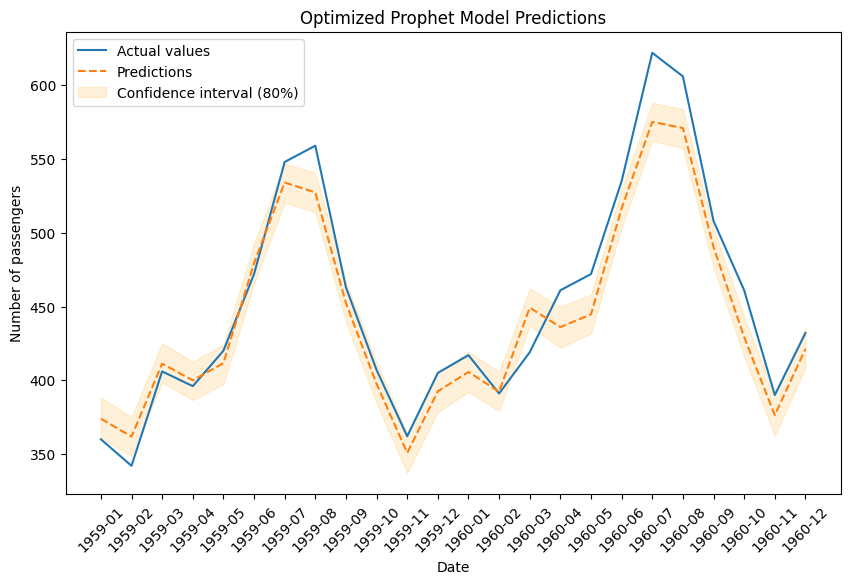

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], df['y'].tail(24), label='Actual values')
plt.plot(df_test['ds'], predictions_tuned['yhat'].tail(24), label='Predictions', linestyle='--')
plt.fill_between(df_test['ds'], predictions_tuned['yhat_lower'].tail(24), predictions_tuned['yhat_upper'].tail(24), 
                 color='orange', alpha=0.15, label='Confidence interval (80%)')
plt.title('Optimized Prophet Model Predictions')
plt.xlabel('Date')
plt.xticks(df_test['ds'], rotation=45)
plt.ylabel('Number of passengers')
plt.legend()
plt.show()